In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tempfile import TemporaryFile
import csv
import numpy as np
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [0]:
X = np.load('/content/gdrive/My Drive/data_4_levels_balanced_128_128_3.npy') 
Y = np.load('/content/gdrive/My Drive/labels_4_levels_balanced.npy')

In [0]:
print(X.shape)
print(X)

(6254, 128, 128, 3)
[[[[193. 193. 185.]
   [193. 193. 185.]
   [193. 193. 185.]
   ...
   [201. 202. 188.]
   [199. 200. 186.]
   [196. 197. 183.]]

  [[194. 194. 186.]
   [194. 194. 186.]
   [194. 194. 186.]
   ...
   [201. 202. 188.]
   [199. 200. 186.]
   [196. 197. 183.]]

  [[195. 195. 187.]
   [195. 195. 187.]
   [195. 195. 187.]
   ...
   [200. 201. 187.]
   [199. 200. 186.]
   [196. 197. 183.]]

  ...

  [[200. 200. 188.]
   [199. 199. 187.]
   [198. 198. 186.]
   ...
   [126. 130. 115.]
   [122. 126. 111.]
   [182. 189. 173.]]

  [[200. 200. 188.]
   [200. 200. 188.]
   [199. 199. 187.]
   ...
   [118. 122. 107.]
   [ 91.  95.  80.]
   [155. 162. 146.]]

  [[200. 200. 188.]
   [200. 200. 188.]
   [199. 199. 187.]
   ...
   [174. 178. 163.]
   [155. 159. 144.]
   [199. 206. 190.]]]


 [[[204. 204. 192.]
   [202. 202. 190.]
   [200. 200. 188.]
   ...
   [209. 207. 195.]
   [210. 208. 196.]
   [214. 212. 200.]]

  [[204. 204. 192.]
   [203. 203. 191.]
   [201. 201. 189.]
   ...
 

In [0]:
print(Y.shape)
print(Y)

(6254, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [0]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

In [0]:
x_train = X[:5254]
y_train = Y[:5254]
print(x_train.shape)
print(y_train.shape)

(5254, 128, 128, 3)
(5254, 4)


In [0]:
x_val = X[5254:5754]
y_val = Y[5254:5754]
print(x_val.shape)
print(y_val.shape)

(500, 128, 128, 3)
(500, 4)


In [0]:
x_test = X[5754:]
y_test = Y[5754:]
print(x_test.shape)
print(y_test.shape)

(500, 128, 128, 3)
(500, 4)


(128, 128, 3)


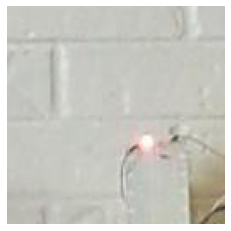

[0. 1. 0. 0.]


In [0]:
# picking a test sample before generating adversarial examples 
Image = x_test[ 10, :]
print( Image.shape )
r,g,b = cv2.split(Image)       # get b,g,r
Image = cv2.merge([r,g,b])

plt.imshow( Image.astype('uint8') )
plt.axis( 'off' )
plt.show( )
print(y_test[10])

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import keras
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))
output = inception.layers[-1].output
output = keras.layers.Flatten()(output)
inception = Model(inception.input, output=output)
for layer in inception.layers:
    layer.trainable = False
inception.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 63, 63, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 63, 63, 32)   0           batch_normalization_1[0][0]      
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.regularizers import l2
model_Sigmoid = Sequential()
model_Sigmoid.add(inception)
model_Sigmoid.add(Dense(512, activation='relu', input_dim=(128,128,3), kernel_regularizer=l2(0.001)))
model_Sigmoid.add(Dropout(0.2))
model_Sigmoid.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_Sigmoid.add(Dropout(0.2))
model_Sigmoid.add(Dense(4, activation='sigmoid'))
model_Sigmoid.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])
model_Sigmoid.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 26,262,308
Trainable params: 4,459,524
Non-trainable params: 21,802,784
__________________________________

In [0]:
# RMSprop ###(lr = 0.001 -> [21.79N, 23.8N, 23.8N])###(lr = 0.0001 -> [23.8N, 23.8N, 22.4N])Overfitting###(lr = 0.00001 -> [23.8N, 23.8N, 23.8N])###
# Adam ###(lr = 0.001 -> [25.99N, 24.6N, 28.0N])Overfitting###(lr = 0.0001 -> [23.8N, 23.8N, 23.8N])Overfitting###(lr = 0.00001 -> [23.8N, 23.8N, 23.8N])###
# SGD ###(lr = 0.001 -> [23.0N, 24.79N, 27.39N])###(lr = 0.0001 -> [0.25N, 23.19N, 23.8N])###(lr = 0.00001 -> [23.8N, 24.4N, 25.0N])###
# N = No learning, GG = Great Learning, OG = Okay Learning, U = Unlearning BNOG = Better than not learning but also somewhat okay learning

#Adam lr = 0.001        ### 28.0% (ANY, lr = ANY, f1 = ANY) ###

model_Sigmoid.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Train on 5254 samples, validate on 500 samples
Epoch 1/10
5254/5254 [==============================] - 186s 35ms/step - loss: 2.1907 - accuracy: 0.2794 - val_loss: 1.5860 - val_accuracy: 0.2480
Epoch 2/10
5254/5254 [==============================] - 181s 34ms/step - loss: 1.6067 - accuracy: 0.2823 - val_loss: 1.4630 - val_accuracy: 0.2480
Epoch 3/10
5254/5254 [==============================] - 182s 35ms/step - loss: 1.5135 - accuracy: 0.3078 - val_loss: 1.4316 - val_accuracy: 0.2480
Epoch 4/10
4224/5254 [=======================>......] - ETA: 32s - loss: 1.5456 - accuracy: 0.3243

In [0]:
model_Sigmoid.evaluate(x_test, y_test)

In [0]:
# predict probabilities for test set
yhat_probs_Sigmoid = model_Sigmoid.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes_Sigmoid = model_Sigmoid.predict_classes(x_test, verbose=0)
yhat_probs_Sigmoid = np.argmax(yhat_probs_Sigmoid, axis=1)
print(yhat_probs_Sigmoid.shape)
print(yhat_classes_Sigmoid.shape)

In [0]:
print(y_test.shape)
y_test_Sigmoid = np.argmax(y_test, axis=1)
print(y_test_Sigmoid.shape)

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy_Sigmoid = accuracy_score(y_test_Sigmoid, yhat_classes_Sigmoid)
print('Accuracy Sigmoid: %f' % accuracy_Sigmoid)
# precision tp / (tp + fp)
precision_Sigmoid = precision_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('Precision Sigmoid: %f' % precision_Sigmoid)
# recall: tp / (tp + fn)
recall_Sigmoid = recall_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('Recall Sigmoid: %f' % recall_Sigmoid)
# f1: 2 tp / (2 tp + fp + fn)
f1_Sigmoid = f1_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('F1 score Sigmoid: %f' % f1_Sigmoid)

In [0]:
model_Softmax = Sequential()
model_Softmax.add(inception)
model_Softmax.add(Dense(512, activation='relu', input_dim=(128,128,3), kernel_regularizer=l2(0.001)))
model_Softmax.add(Dropout(0.2))
model_Softmax.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_Softmax.add(Dropout(0.2))
model_Softmax.add(Dense(4, activation='softmax'))
model_Softmax.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])
model_Softmax.summary()

In [0]:
# RMSprop ###(lr = 0.001 -> [23.8N, 37.2N, 24.19N])Overfitting###(lr = 0.0001 -> [24.79N, 23.9N, 24.79N])Overfitting###(lr = 0.00001 -> [31.79NOG, 34.0NOG, 31.4NOG])###
# Adam ###(lr = 0.001 -> [26.39N, 31.79N, 21.99N])###(lr = 0.0001 -> [23.0N, 26.39N, 20.99N])Overfitting###(lr = 0.00001 -> [22.4N, 24.79N, 18.6N])###
# SGD ###(lr = 0.001 -> [29.6N, 24.79N, 28.2N])###(lr = 0.0001 -> [22.4N, 25.0N, 30.39N])###(lr = 0.00001 -> [37.59OG, 25.6N, 25.0N])###
# N = No learning, GG = Great Learning, OG = Okay Learning, U = Unlearning BNOG = Better than not learning but also somewhat okay learning

#SGD lr = 0.00001         ### 37.59% (SGD, lr = 0.00001, f1 = 0.233770) ###

model_Softmax.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

In [0]:
model_Softmax.evaluate(x_test, y_test)

In [0]:
# predict probabilities for test set
yhat_probs_Softmax = model_Softmax.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes_Softmax = model_Softmax.predict_classes(x_test, verbose=0)
yhat_probs_Softmax = np.argmax(yhat_probs_Softmax, axis=1)
print(yhat_probs_Softmax.shape)
print(yhat_classes_Softmax.shape)

In [0]:
print(y_test.shape)
y_test_Softmax = np.argmax(y_test, axis=1)
print(y_test_Softmax.shape)

In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy_Softmax = accuracy_score(y_test_Softmax, yhat_classes_Softmax)
print('Accuracy Softmax: %f' % accuracy_Softmax)
# precision tp / (tp + fp)
precision_Softmax = precision_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('Precision Softmax: %f' % precision_Softmax)
# recall: tp / (tp + fn)
recall_Softmax = recall_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('Recall Softmax: %f' % recall_Softmax)
# f1: 2 tp / (2 tp + fp + fn)
f1_Softmax = f1_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('F1 score Softmax: %f' % f1_Softmax)